In [1]:
import tensorflow as tf
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)

In [2]:
import keras
import pandas as pd
import tensorflow as tf

import numpy as np
# from keras.models import Sequential, Model
# from keras.layers import Dense, Dropout, Activation, Flatten, Convolution2D, MaxPooling2D, GlobalAveragePooling2D
from keras.utils import np_utils

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Convolution2D, MaxPooling2D, GlobalAveragePooling2D, Input,AveragePooling2D, BatchNormalization, LeakyReLU, SpatialDropout2D

# from keras.applications import MobileNet
# from keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2, InceptionV3
from tensorflow.keras.optimizers import Adam

from matplotlib import pyplot as plt
import os
from sklearn.model_selection import train_test_split

import seaborn as sns
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.model_selection import KFold

from collections import defaultdict,Counter
from imblearn.over_sampling import SMOTE
from PIL import Image

from kerastuner import HyperModel

Using TensorFlow backend.


<h2>Data Loading and Preparation</h2>

In [3]:
def getSpeciesCode(x):
    part = x.split('_')
    if part[0] == 'ASETRI':
        return 0
    elif part[0] == 'EPTBOT':
        return 1
    elif part[0] == 'MYOEMA':
        return 2
    elif part[0] == 'PIPKUH':
        return 3
    elif part[0] == 'RHIMUS':
        return 4
    elif part[0] == 'RHYNAS':
        return 5
    elif part[0] == 'ROUAEG':
        return 6
    elif part[0] == 'TAPPER':
        return 7
    else:
        return 'Unknown'
    
def getSpecies(x):
    if x == 0:
        return 'A.tridens'
    elif x == 1:
        return 'E.bottae'
    elif x == 2:
        return 'M.emarginatus'
    elif x == 3:
        return 'P.kuhli'
    elif x == 4:
        return 'R.muscatellum'
    elif x == 5:
        return 'R.nasutus'
    elif x == 6:
        return 'R.aegyptius'
    elif x == 7:
        return 'T.perforatus'
    else:
        return 'Unknown'
    
    
def generate_actual_predicted(Y_pred, X_test, Y_test): 
    predicted = list()
    for i in range(len(Y_pred)):
        predicted.append(np.argmax(Y_pred[i]))
        
    actual = list()
    for i in range(len(Y_test)):
        actual.append(np.argmax(Y_test[i]))
        
    return actual, predicted

In [4]:
image_folder_path = '../data/SpectogramInitial'
file_paths = [f for f in os.listdir(image_folder_path)]
species = []
for file_name in file_paths:
    sp = file_name.split('_')
    species.append(sp[0])

df = pd.DataFrame(species, columns=['Species'])
df['Species'].value_counts()

RHIMUS    1665
TAPPER     403
PIPKUH     299
RHYNAS     269
EPTBOT     124
ROUAEG     121
MYOEMA     112
ASETRI      25
Name: Species, dtype: int64

In [5]:
X_all = []
Y_all = []

image_folder_path = '../data/SpectogramInitial'
file_paths = [f for f in os.listdir(image_folder_path)]

for file_name in file_paths:
    spectrogram = Image.open(image_folder_path + '/' + file_name)
    spectrogram = spectrogram.convert('RGB')
    spectrogram = spectrogram.resize((170, 112))  
    spectrogram = np.array(spectrogram)
    #spectrogram = np.expand_dims(spectrogram, axis=2) 
    X_all.append(spectrogram)
    Y_all.append(getSpeciesCode(file_name))


In [6]:
X_all = np.array(X_all)
Y_all = np.array(Y_all)

print(X_all.shape)
print(Y_all.shape)

X_all = X_all.astype('float32')
X_all /= 255

Y_all = np_utils.to_categorical(Y_all, num_classes=8) 


(3018, 112, 170, 3)
(3018,)


In [7]:
# train /test= 80/20% split
# Data is stratified
X_train, X_test, Y_train, Y_test = train_test_split(X_all, Y_all, test_size=0.2, random_state = 245, stratify=Y_all)


<h2> V1 !!!!! K-Fold Training and Evaluation</h2>

In [8]:
def build_current_model():
    inp = Input(shape=(112,170,3))
    lay = Convolution2D(filters=56,kernel_size=(7,7),strides=(2,2),padding='same')(inp)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = MaxPooling2D(pool_size=(2,2),strides=2,padding='same')(lay)
    lay = Dropout(0.3)(lay)

    lay = Convolution2D(filters=72,kernel_size=(5,5),strides=(2,2),padding='same')(lay)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(lay)
    lay = Dropout(0.3)(lay)

    lay = Convolution2D(filters=56,kernel_size=(3,3),strides=(1,1),padding='same')(lay)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(lay)
    lay = Dropout(0.3)(lay)

    lay = Convolution2D(filters=72,kernel_size=(3,3),strides=(1,1),padding='same')(lay)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(lay)
    lay = Dropout(0.3)(lay)

    lay = Flatten()(lay)

    lay = Dense(48)(lay)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = Dropout(0.15)(lay)

    x_out = Dense(8, name='output', activation='softmax')(lay)
    model = Model(inputs=inp, outputs=x_out)
    model.compile(
        optimizer=Adam(lr=0.003),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model


In [9]:
model = build_current_model()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 112, 170, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 56, 85, 56)        8288      
_________________________________________________________________
batch_normalization (BatchNo (None, 56, 85, 56)        224       
_________________________________________________________________
activation (Activation)      (None, 56, 85, 56)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 28, 43, 56)        0         
_________________________________________________________________
dropout (Dropout)            (None, 28, 43, 56)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 22, 72)        100872

In [10]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, precision_recall_curve
from sklearn.metrics import confusion_matrix

all_base_precision = list()
all_base_recall = list()
all_macro_precision = list()
all_macro_recall = list()
all_f1 = list()
all_macro_f1 = list()


all_tpr = list()
all_fpr = list()
all_precision = list()
all_recall = list()
all_cm=list()
all_accuracy = list()

all_df = list()

n_split=10
n_classes=8

y_all_labelled=[]
for i in range(len(Y_all)):
        y_all_labelled.append(np.argmax(Y_all[i]))
        
my_callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=20,verbose=1, mode='min',restore_best_weights=True)]
       
for train_index,test_index in StratifiedKFold(n_split, shuffle=True, random_state=123).split(X_all,y_all_labelled):  
    # use the index to generate training an testing sets
    x_train,x_test=X_all[train_index],X_all[test_index]
    y_train,y_test=Y_all[train_index],Y_all[test_index]

    # create and fit the model
    cv_model=build_current_model() # lr,dense,cnn
    history = cv_model.fit(x_train, y_train,
              batch_size=8,
              epochs=100,
              validation_split=0.2,
              verbose=2,
              callbacks=my_callbacks)
    
    #for loss,acc plots
    history_info = history.history
    df_history_info = pd.DataFrame(history_info) 
    all_df.append(df_history_info)
    
    #generate predictions
    y_pred = cv_model.predict(x_test)
    actual, predicted = generate_actual_predicted(y_pred, x_test, y_test)

    #calc metrics
    curr_base_prec, curr_base_rec, curr_f1, _ = precision_recall_fscore_support(actual, predicted)
    curr_macro_prec = precision_score(actual, predicted,average='macro')
    curr_macro_rec = recall_score(actual, predicted,average='macro')
    curr_macro_f1 = f1_score(actual, predicted,average='macro')
    
    
    actual_labeled = list()
    predict_labeled = list()
    for x,y in zip(actual,predicted):
        actual_labeled.append(getSpecies(x))
        predict_labeled.append(getSpecies(y))
        
    labels = ['A.tridens','E.bottae','M.emarginatus','P.kuhli','R.muscatellum','R.nasutus', 'R.aegyptius', 'T.perforatus']
    curr_cm=confusion_matrix(actual_labeled,predict_labeled,labels=labels)
    
    curr_fpr = [0] * n_classes
    curr_tpr = [0] * n_classes
    for i in range(n_classes):
        curr_fpr[i], curr_tpr[i], _ = roc_curve(y_test[:,i], y_pred[:,i])
        
    curr_prec = [0] * n_classes
    curr_rec = [0] * n_classes
    for i in range(n_classes):
        curr_prec[i], curr_rec[i], _ = precision_recall_curve(y_test[:,i], y_pred[:,i])

        
    curr_accuracy = accuracy_score(actual, predicted)
    
    #add to lists
    all_base_precision.append(curr_base_prec)
    all_base_recall.append(curr_base_rec)
    all_macro_precision.append(curr_macro_prec)
    all_macro_recall.append(curr_macro_rec)
    
    all_f1.append(curr_f1)
    all_macro_f1.append(curr_macro_f1)
    
    all_accuracy.append(curr_accuracy)

    
    all_fpr.append(curr_fpr)
    all_tpr.append(curr_tpr)
    all_precision.append(curr_prec)
    all_recall.append(curr_rec)
    all_cm.append(curr_cm)
    
    
    

Epoch 1/100
272/272 - 13s - loss: 1.4135 - accuracy: 0.5456 - val_loss: 1.2562 - val_accuracy: 0.5588
Epoch 2/100
272/272 - 2s - loss: 1.1932 - accuracy: 0.6169 - val_loss: 1.2450 - val_accuracy: 0.6213
Epoch 3/100
272/272 - 2s - loss: 1.0145 - accuracy: 0.6584 - val_loss: 1.0611 - val_accuracy: 0.6526
Epoch 4/100
272/272 - 2s - loss: 0.9091 - accuracy: 0.6929 - val_loss: 0.8436 - val_accuracy: 0.7059
Epoch 5/100
272/272 - 2s - loss: 0.8192 - accuracy: 0.7343 - val_loss: 0.6966 - val_accuracy: 0.7353
Epoch 6/100
272/272 - 2s - loss: 0.7069 - accuracy: 0.7684 - val_loss: 0.5979 - val_accuracy: 0.8015
Epoch 7/100
272/272 - 2s - loss: 0.6610 - accuracy: 0.7882 - val_loss: 0.5581 - val_accuracy: 0.8235
Epoch 8/100
272/272 - 2s - loss: 0.5840 - accuracy: 0.8080 - val_loss: 0.4510 - val_accuracy: 0.8419
Epoch 9/100
272/272 - 2s - loss: 0.5561 - accuracy: 0.8163 - val_loss: 0.3866 - val_accuracy: 0.8658
Epoch 10/100
272/272 - 2s - loss: 0.4701 - accuracy: 0.8453 - val_loss: 0.3701 - val_accur

Epoch 82/100
272/272 - 2s - loss: 0.1121 - accuracy: 0.9627 - val_loss: 0.1369 - val_accuracy: 0.9632
Epoch 83/100
272/272 - 2s - loss: 0.0986 - accuracy: 0.9655 - val_loss: 0.1118 - val_accuracy: 0.9632
Epoch 84/100
272/272 - 2s - loss: 0.0979 - accuracy: 0.9669 - val_loss: 0.1123 - val_accuracy: 0.9614
Epoch 85/100
272/272 - 2s - loss: 0.0924 - accuracy: 0.9673 - val_loss: 0.1113 - val_accuracy: 0.9706
Epoch 86/100
272/272 - 2s - loss: 0.0906 - accuracy: 0.9669 - val_loss: 0.1413 - val_accuracy: 0.9688
Epoch 87/100
272/272 - 2s - loss: 0.0675 - accuracy: 0.9788 - val_loss: 0.0973 - val_accuracy: 0.9651
Epoch 88/100
272/272 - 2s - loss: 0.0948 - accuracy: 0.9719 - val_loss: 0.0728 - val_accuracy: 0.9743
Epoch 89/100
272/272 - 2s - loss: 0.0854 - accuracy: 0.9724 - val_loss: 0.0792 - val_accuracy: 0.9798
Epoch 90/100
272/272 - 2s - loss: 0.0890 - accuracy: 0.9701 - val_loss: 0.0977 - val_accuracy: 0.9724
Epoch 91/100
272/272 - 2s - loss: 0.0632 - accuracy: 0.9802 - val_loss: 0.1034 - v

Epoch 68/100
272/272 - 2s - loss: 0.1000 - accuracy: 0.9655 - val_loss: 0.0834 - val_accuracy: 0.9743
Epoch 69/100
272/272 - 2s - loss: 0.1075 - accuracy: 0.9655 - val_loss: 0.0946 - val_accuracy: 0.9706
Epoch 70/100
272/272 - 2s - loss: 0.1000 - accuracy: 0.9673 - val_loss: 0.0952 - val_accuracy: 0.9688
Epoch 71/100
272/272 - 2s - loss: 0.1183 - accuracy: 0.9618 - val_loss: 0.1074 - val_accuracy: 0.9632
Epoch 72/100
272/272 - 2s - loss: 0.0978 - accuracy: 0.9682 - val_loss: 0.1480 - val_accuracy: 0.9614
Epoch 73/100
272/272 - 2s - loss: 0.1045 - accuracy: 0.9641 - val_loss: 0.1040 - val_accuracy: 0.9688
Epoch 74/100
272/272 - 2s - loss: 0.1111 - accuracy: 0.9645 - val_loss: 0.1164 - val_accuracy: 0.9632
Epoch 75/100
272/272 - 2s - loss: 0.0914 - accuracy: 0.9719 - val_loss: 0.0754 - val_accuracy: 0.9779
Epoch 76/100
272/272 - 2s - loss: 0.0812 - accuracy: 0.9756 - val_loss: 0.1272 - val_accuracy: 0.9559
Epoch 77/100
272/272 - 2s - loss: 0.0985 - accuracy: 0.9669 - val_loss: 0.1751 - v

Epoch 49/100
272/272 - 2s - loss: 0.1268 - accuracy: 0.9604 - val_loss: 0.1048 - val_accuracy: 0.9651
Epoch 50/100
272/272 - 2s - loss: 0.1172 - accuracy: 0.9609 - val_loss: 0.1502 - val_accuracy: 0.9596
Epoch 51/100
272/272 - 2s - loss: 0.1587 - accuracy: 0.9503 - val_loss: 0.1886 - val_accuracy: 0.9393
Epoch 52/100
272/272 - 2s - loss: 0.1310 - accuracy: 0.9595 - val_loss: 0.1003 - val_accuracy: 0.9651
Epoch 53/100
272/272 - 2s - loss: 0.1454 - accuracy: 0.9498 - val_loss: 0.1598 - val_accuracy: 0.9467
Epoch 54/100
272/272 - 2s - loss: 0.1419 - accuracy: 0.9558 - val_loss: 0.1392 - val_accuracy: 0.9596
Epoch 55/100
272/272 - 2s - loss: 0.1285 - accuracy: 0.9558 - val_loss: 0.1212 - val_accuracy: 0.9651
Epoch 56/100
272/272 - 2s - loss: 0.1202 - accuracy: 0.9636 - val_loss: 0.1093 - val_accuracy: 0.9706
Epoch 57/100
272/272 - 2s - loss: 0.0975 - accuracy: 0.9701 - val_loss: 0.1433 - val_accuracy: 0.9632
Epoch 58/100
272/272 - 2s - loss: 0.1118 - accuracy: 0.9613 - val_loss: 0.1203 - v

Epoch 42/100
272/272 - 2s - loss: 0.1677 - accuracy: 0.9452 - val_loss: 0.1503 - val_accuracy: 0.9449
Epoch 43/100
272/272 - 2s - loss: 0.1830 - accuracy: 0.9401 - val_loss: 0.1292 - val_accuracy: 0.9577
Epoch 44/100
272/272 - 2s - loss: 0.1619 - accuracy: 0.9494 - val_loss: 0.1566 - val_accuracy: 0.9467
Epoch 45/100
272/272 - 2s - loss: 0.1502 - accuracy: 0.9526 - val_loss: 0.2682 - val_accuracy: 0.9081
Epoch 46/100
272/272 - 2s - loss: 0.1479 - accuracy: 0.9535 - val_loss: 0.1137 - val_accuracy: 0.9577
Epoch 47/100
272/272 - 2s - loss: 0.1308 - accuracy: 0.9535 - val_loss: 0.1548 - val_accuracy: 0.9430
Epoch 48/100
272/272 - 2s - loss: 0.1555 - accuracy: 0.9494 - val_loss: 0.0903 - val_accuracy: 0.9688
Epoch 49/100
272/272 - 2s - loss: 0.1420 - accuracy: 0.9558 - val_loss: 0.1571 - val_accuracy: 0.9430
Epoch 50/100
272/272 - 2s - loss: 0.1474 - accuracy: 0.9498 - val_loss: 0.0854 - val_accuracy: 0.9743
Epoch 51/100
272/272 - 2s - loss: 0.1346 - accuracy: 0.9558 - val_loss: 0.0810 - v

Epoch 43/100
272/272 - 2s - loss: 0.1690 - accuracy: 0.9498 - val_loss: 0.1560 - val_accuracy: 0.9449
Epoch 44/100
272/272 - 1s - loss: 0.1507 - accuracy: 0.9503 - val_loss: 0.1593 - val_accuracy: 0.9393
Epoch 45/100
272/272 - 2s - loss: 0.1425 - accuracy: 0.9530 - val_loss: 0.1169 - val_accuracy: 0.9577
Epoch 46/100
272/272 - 2s - loss: 0.1243 - accuracy: 0.9540 - val_loss: 0.1510 - val_accuracy: 0.9467
Epoch 47/100
272/272 - 2s - loss: 0.1454 - accuracy: 0.9512 - val_loss: 0.1348 - val_accuracy: 0.9577
Epoch 48/100
272/272 - 2s - loss: 0.1278 - accuracy: 0.9581 - val_loss: 0.2240 - val_accuracy: 0.9375
Epoch 49/100
272/272 - 2s - loss: 0.1575 - accuracy: 0.9503 - val_loss: 0.2231 - val_accuracy: 0.9228
Epoch 50/100
272/272 - 2s - loss: 0.1413 - accuracy: 0.9530 - val_loss: 0.1585 - val_accuracy: 0.9559
Epoch 51/100
272/272 - 2s - loss: 0.1436 - accuracy: 0.9558 - val_loss: 0.1653 - val_accuracy: 0.9430
Epoch 52/100
272/272 - 2s - loss: 0.1098 - accuracy: 0.9641 - val_loss: 0.1406 - v

Epoch 50/100
272/272 - 2s - loss: 0.1357 - accuracy: 0.9553 - val_loss: 0.1161 - val_accuracy: 0.9596
Epoch 51/100
272/272 - 2s - loss: 0.1300 - accuracy: 0.9558 - val_loss: 0.1891 - val_accuracy: 0.9559
Epoch 52/100
272/272 - 2s - loss: 0.1493 - accuracy: 0.9517 - val_loss: 0.1680 - val_accuracy: 0.9485
Epoch 53/100
272/272 - 2s - loss: 0.1265 - accuracy: 0.9595 - val_loss: 0.1728 - val_accuracy: 0.9412
Epoch 54/100
272/272 - 2s - loss: 0.1069 - accuracy: 0.9678 - val_loss: 0.1847 - val_accuracy: 0.9430
Epoch 55/100
272/272 - 2s - loss: 0.1064 - accuracy: 0.9622 - val_loss: 0.1061 - val_accuracy: 0.9724
Epoch 56/100
272/272 - 1s - loss: 0.1189 - accuracy: 0.9678 - val_loss: 0.1173 - val_accuracy: 0.9559
Epoch 57/100
272/272 - 2s - loss: 0.1223 - accuracy: 0.9627 - val_loss: 0.2310 - val_accuracy: 0.9283
Epoch 58/100
272/272 - 2s - loss: 0.1232 - accuracy: 0.9563 - val_loss: 0.1364 - val_accuracy: 0.9577
Epoch 59/100
272/272 - 2s - loss: 0.1058 - accuracy: 0.9636 - val_loss: 0.1445 - v

Epoch 31/100
272/272 - 1s - loss: 0.2322 - accuracy: 0.9250 - val_loss: 0.2178 - val_accuracy: 0.9375
Epoch 32/100
272/272 - 2s - loss: 0.2090 - accuracy: 0.9328 - val_loss: 0.1967 - val_accuracy: 0.9320
Epoch 33/100
272/272 - 2s - loss: 0.2006 - accuracy: 0.9420 - val_loss: 0.1304 - val_accuracy: 0.9596
Epoch 34/100
272/272 - 2s - loss: 0.1719 - accuracy: 0.9466 - val_loss: 0.1237 - val_accuracy: 0.9577
Epoch 35/100
272/272 - 1s - loss: 0.1845 - accuracy: 0.9397 - val_loss: 0.1613 - val_accuracy: 0.9467
Epoch 36/100
272/272 - 2s - loss: 0.1836 - accuracy: 0.9406 - val_loss: 0.2462 - val_accuracy: 0.9173
Epoch 37/100
272/272 - 1s - loss: 0.1742 - accuracy: 0.9411 - val_loss: 0.2032 - val_accuracy: 0.9338
Epoch 38/100
272/272 - 2s - loss: 0.1998 - accuracy: 0.9374 - val_loss: 0.1203 - val_accuracy: 0.9614
Epoch 39/100
272/272 - 2s - loss: 0.1654 - accuracy: 0.9471 - val_loss: 0.2356 - val_accuracy: 0.9154
Epoch 40/100
272/272 - 2s - loss: 0.1618 - accuracy: 0.9424 - val_loss: 0.1540 - v

Epoch 12/100
272/272 - 2s - loss: 0.4465 - accuracy: 0.8587 - val_loss: 0.4087 - val_accuracy: 0.8382
Epoch 13/100
272/272 - 1s - loss: 0.4139 - accuracy: 0.8660 - val_loss: 0.5503 - val_accuracy: 0.8456
Epoch 14/100
272/272 - 2s - loss: 0.4093 - accuracy: 0.8656 - val_loss: 0.3391 - val_accuracy: 0.8897
Epoch 15/100
272/272 - 2s - loss: 0.3748 - accuracy: 0.8803 - val_loss: 0.2383 - val_accuracy: 0.9210
Epoch 16/100
272/272 - 2s - loss: 0.3586 - accuracy: 0.8780 - val_loss: 0.2381 - val_accuracy: 0.9154
Epoch 17/100
272/272 - 2s - loss: 0.3440 - accuracy: 0.8886 - val_loss: 0.2845 - val_accuracy: 0.9062
Epoch 18/100
272/272 - 2s - loss: 0.3210 - accuracy: 0.8927 - val_loss: 0.1987 - val_accuracy: 0.9265
Epoch 19/100
272/272 - 2s - loss: 0.3447 - accuracy: 0.8849 - val_loss: 0.2610 - val_accuracy: 0.9118
Epoch 20/100
272/272 - 2s - loss: 0.2512 - accuracy: 0.9093 - val_loss: 0.2398 - val_accuracy: 0.9246
Epoch 21/100
272/272 - 2s - loss: 0.2706 - accuracy: 0.9079 - val_loss: 0.3866 - v

Epoch 24/100
272/272 - 2s - loss: 0.2226 - accuracy: 0.9264 - val_loss: 0.1953 - val_accuracy: 0.9393
Epoch 25/100
272/272 - 2s - loss: 0.2366 - accuracy: 0.9199 - val_loss: 0.3529 - val_accuracy: 0.8879
Epoch 26/100
272/272 - 2s - loss: 0.2213 - accuracy: 0.9264 - val_loss: 0.1383 - val_accuracy: 0.9375
Epoch 27/100
272/272 - 2s - loss: 0.2132 - accuracy: 0.9305 - val_loss: 0.1762 - val_accuracy: 0.9338
Epoch 28/100
272/272 - 2s - loss: 0.1788 - accuracy: 0.9406 - val_loss: 0.1234 - val_accuracy: 0.9522
Epoch 29/100
272/272 - 2s - loss: 0.1841 - accuracy: 0.9448 - val_loss: 0.1775 - val_accuracy: 0.9449
Epoch 30/100
272/272 - 2s - loss: 0.2120 - accuracy: 0.9301 - val_loss: 0.1660 - val_accuracy: 0.9338
Epoch 31/100
272/272 - 2s - loss: 0.2029 - accuracy: 0.9301 - val_loss: 0.1400 - val_accuracy: 0.9467
Epoch 32/100
272/272 - 2s - loss: 0.1937 - accuracy: 0.9374 - val_loss: 0.1283 - val_accuracy: 0.9522
Epoch 33/100
272/272 - 2s - loss: 0.1925 - accuracy: 0.9360 - val_loss: 0.1794 - v

Epoch 28/100
272/272 - 1s - loss: 0.2404 - accuracy: 0.9162 - val_loss: 0.2680 - val_accuracy: 0.9210
Epoch 29/100
272/272 - 2s - loss: 0.2018 - accuracy: 0.9296 - val_loss: 0.6357 - val_accuracy: 0.7849
Epoch 30/100
272/272 - 2s - loss: 0.2136 - accuracy: 0.9324 - val_loss: 0.2075 - val_accuracy: 0.9320
Epoch 31/100
272/272 - 2s - loss: 0.1754 - accuracy: 0.9434 - val_loss: 0.1751 - val_accuracy: 0.9467
Epoch 32/100
272/272 - 1s - loss: 0.1988 - accuracy: 0.9365 - val_loss: 0.2597 - val_accuracy: 0.9062
Epoch 33/100
272/272 - 2s - loss: 0.1846 - accuracy: 0.9347 - val_loss: 0.2006 - val_accuracy: 0.9375
Epoch 34/100
272/272 - 2s - loss: 0.2315 - accuracy: 0.9264 - val_loss: 0.1850 - val_accuracy: 0.9412
Epoch 35/100
272/272 - 2s - loss: 0.1888 - accuracy: 0.9305 - val_loss: 0.1530 - val_accuracy: 0.9485
Epoch 36/100
272/272 - 2s - loss: 0.2016 - accuracy: 0.9379 - val_loss: 0.1952 - val_accuracy: 0.9301
Epoch 37/100
272/272 - 2s - loss: 0.2021 - accuracy: 0.9333 - val_loss: 0.1715 - v

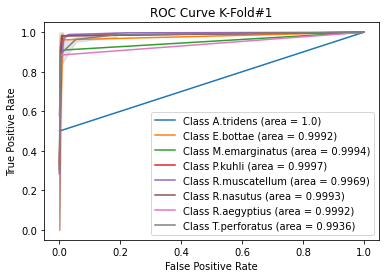

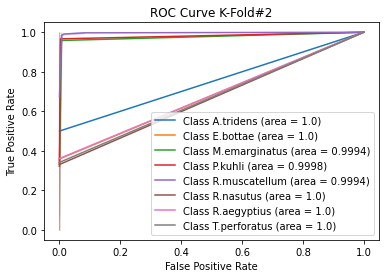

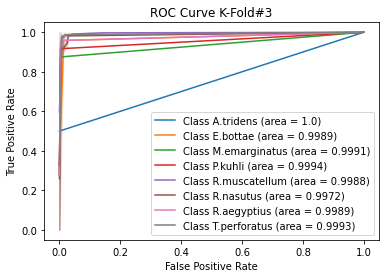

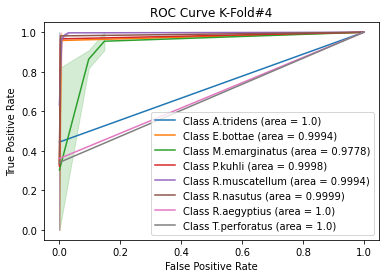

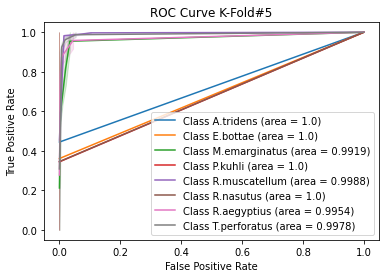

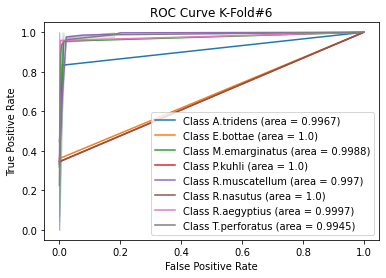

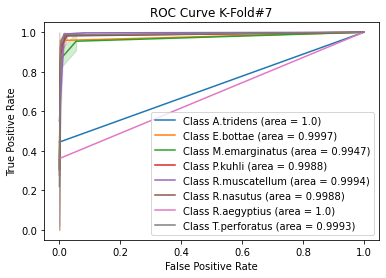

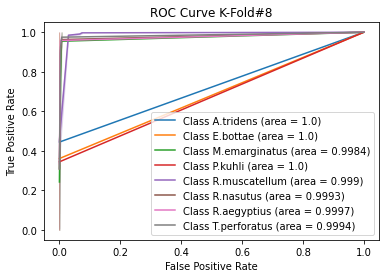

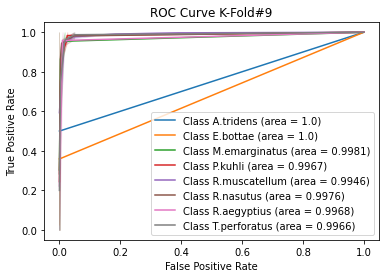

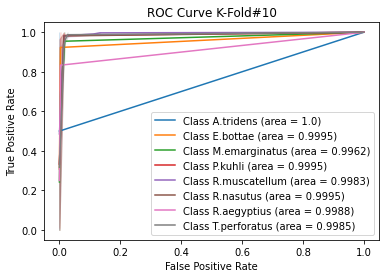

In [13]:
# Plot all K-Fold ROC curves

for i in range(n_split):
    _, axs = plt.subplots(ncols=1)
    axs.set(xlabel='False Positive Rate',ylabel='True Positive Rate', title='ROC Curve K-Fold#'+str(i+1))
    for j in range(n_classes):
        auc_val = auc(all_fpr[i][j], all_tpr[i][j])
        auc_val = np.around(auc_val,4)
        sns.lineplot(x=all_fpr[i][j],y=all_tpr[i][j],ax=axs, label='Class '+ getSpecies(j) +' (area = ' + str(auc_val) + ')', legend='brief')
        